Number of wind farms before filtering: 105


/opt/anaconda3/envs/geospatial_env/lib/python3.9/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


Number of wind farms after shore filtering: 84
Number of wind farms after proximity filtering (1 nm): 62


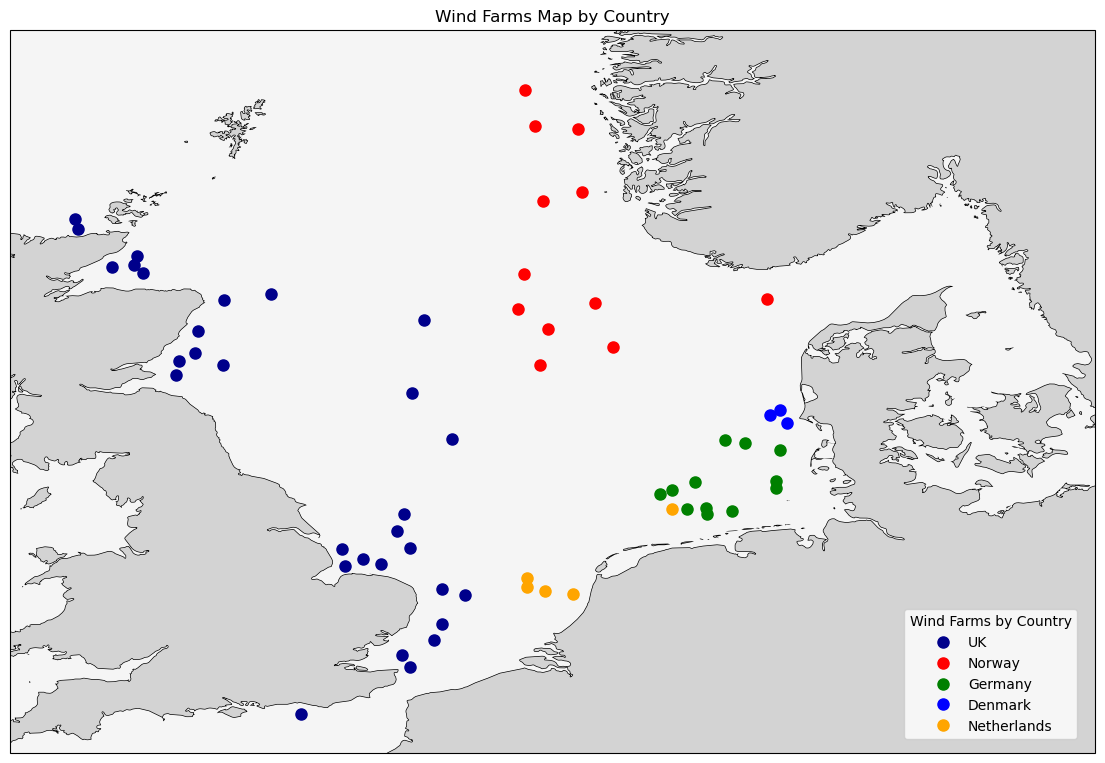

Wrote 62 rows to /Users/markusagersborg/Library/CloudStorage/OneDrive-NTNU/Master/Optimeringsmodell/Model1/wind_farms_final.xlsx
Wrote 62 wind farms to /Users/markusagersborg/Library/CloudStorage/OneDrive-NTNU/Master/Optimeringsmodell/Model1/wind_farms_final.txt


In [1]:
#import pandas as pd
from geopy.distance import geodesic
from gurobipy import Model, GRB, quicksum
from collections import defaultdict, OrderedDict
import numpy as np
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys
import math
import json

# Get the absolute path of the parent directory and insert into sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from Prepare_wind_farm_list import wind_farm_list

# Remove Sofia (Teesside B) as it is duplicated in the wind_farm_list
for wf in wind_farm_list:
    if wf["name"] == "Sofia (Teesside B)":
        wind_farm_list.remove(wf)
        break 

In [2]:
vessel_info = [
    {
      'vessel_id': 1,
      'name': 'Vessel 1: GBABD -> NOBGO',
      'start': {'name': 'Port of Aberdeen',     'lat': 57.14, 'lon': -2.08},
      'end':  {'name': 'Port of Bergen',    'lat': 60.39, 'lon': 5.32},
      'CS': 10.0,
      'FC': 0.2,
      'CLO': 100.0,
      'Q': 1000.0,
      'speed': 15,          
      'charging_rate': 2, 
      'time_penalty': 0
    },
    {
      'vessel_id': 2,
      'name': 'Vessel 2: GBABD -> NOBGO',
      'start': {'name': 'Port of Aberdeen',     'lat': 57.14, 'lon': -2.08},
      'end':  {'name': 'Port of Bergen',    'lat': 60.39, 'lon': 5.32},
      'CS': 20,
      'FC': 0.2,
      'CLO': 50.0,
      'Q': 1000.0,
      'speed': 15,         
      'charging_rate': 2, 
      'time_penalty': 0
    }
]

full_charge_mode = 0 # 0: flexible charging, 1: forced full recharge at each node

# Pick scenario
vdata = vessel_info[0]
vessel_name = vdata['name']
v_start_name = vdata['start']['name']
v_end_name   = vdata['end']['name']

CS  = vdata['CS']    # cost factor per nm
FC  = vdata['FC']    # fuel consumption per nm
CLO = vdata['CLO']   # lost opportunity cost factor
Q   = vdata['Q']     # total fuel capacity
speed = vdata['speed'] # nm per hour
charging_rate = vdata['charging_rate'] # energy units per hour
time_penalty = vdata['time_penalty'] # time cost per hour


all_nodes = []

# Origin port
all_nodes.append({
    'name': vdata['start']['name'],
    'lat':  vdata['start']['lat'],
    'lon':  vdata['start']['lon'],
    'type': "start"
})

# Destination port
all_nodes.append({
    'name': vdata['end']['name'],
    'lat':  vdata['end']['lat'],
    'lon':  vdata['end']['lon'],
    'type': "end"
})

# Add wind farms
for wf in wind_farm_list:
    all_nodes.append({
        'name': wf['name'],
        'lat':  wf['lat'],
        'lon':  wf['lon'],
        'type': 'wind_farm'
    })

# Create nodes_dict
nodes_dict = {}
for i, nd in enumerate(all_nodes):
    nodes_dict[i] = nd

N = list(nodes_dict.keys())

def find_node_index_by_name(name):
    for idx in N:
        if nodes_dict[idx]['name'] == name:
            return idx
    return None

start_idx = find_node_index_by_name(v_start_name)
end_idx   = find_node_index_by_name(v_end_name)

wind_farms = [i for i in N if nodes_dict[i]['type'] == 'wind_farm']


# Build arc set A
vessel_node_set = [start_idx, end_idx] + wind_farms

A = []
for i in vessel_node_set:
    for j in vessel_node_set:
        if i != j:
            A.append((i, j))

# Distances in nautical miles
D_ij = {}
for i in N:
    for j in N:
        if i != j:
            lat_i, lon_i = nodes_dict[i]['lat'], nodes_dict[i]['lon']
            lat_j, lon_j = nodes_dict[j]['lat'], nodes_dict[j]['lon']
            dist_nm = geodesic((lat_i, lon_i), (lat_j, lon_j)).nm
            D_ij[(i, j)] = dist_nm


# Energy cost
CB_i = {}
for i in N:
    if nodes_dict[i]['type'] == 'wind_farm':
        CB_i[i] = 10.0  
    else:
        CB_i[i] = 5.0

In [3]:
model = Model("Single_Vessel")

# Decision variable: z[(i,j)] = 1 if vessel travels from node i to j
z = {}
for (i, j) in A:
    z[(i, j)] = model.addVar(vtype=GRB.BINARY, name=f"z_v{i}_{j}")

# Decision variable: y[i] = 1 if a wind farm station is built at node i
y = {}
for i in N:
    if nodes_dict[i]['type'] == 'wind_farm':
        y[i] = model.addVar(vtype=GRB.BINARY, name=f"y_{i}")
    else:
        y[i] = model.addVar(vtype=GRB.BINARY, lb=0, ub=0, name=f"y_{i}")

# Installed Battery Capacity: q
q = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="q")

# Battery and Charging Variables:
battery = {}
charge = {}
for i in nodes_dict:
    battery[i] = model.addVar(lb=0, name=f"battery_v_{i}")
    charge[i] = model.addVar(lb=0, name=f"charge_v_{i}")

# Objective Function
obj = quicksum(CS * D_ij[(i, j)] * z[(i, j)] for (i, j) in A) # Sailing cost

obj += quicksum(CB_i[i] * charge[i] for i in nodes_dict) # Energy cost

obj += CLO * q  # Lost opportunity cost

time_sailing = quicksum((D_ij[(i, j)] / speed) * z[(i, j)] for (i, j) in A) # Sailing time
time_charging = quicksum(charge[i] / charging_rate for i in nodes_dict) # Charging time
obj += time_penalty * (time_sailing + time_charging) # Time cost

model.setObjective(obj, GRB.MINIMIZE)

# Constraints
for i in nodes_dict: # Link battery level to installed capacity: battery at any node must not exceed q_v.
    model.addConstr(battery[i] <= q, name=f"battery_cap_{i}")

model.addConstr(battery[start_idx] == q, name=f"init_battery") # Initial condition: at the start port, battery equals the installed capacity.

if full_charge_mode == 1: # Set full_charge_mode = 1 to force full charge at each node, or 0 to optimize charging amounts.
    for i in nodes_dict:
        if i != start_idx and i != end_idx:
            model.addConstr(battery[i] == q, name=f"full_charge_{i}")

        model.addConstr(battery[end_idx] == q, name="full_charge_end")
else:
    model.addConstr(battery[end_idx] == q, name="full_charge_end")

model.addConstr(quicksum(z[(start_idx, j)] for (i, j) in A if i == start_idx) == 1, name=f"DepartStart") # One departure from the start port

model.addConstr(quicksum(z[(i, end_idx)] for (i, j) in A if j == end_idx) == 1, name=f"ArriveEnd") # One arrival at the end port

for nd in [start_idx] + wind_farms + [end_idx]: # Flow conservation at intermediate nodes
    if nd not in [start_idx, end_idx]:
        model.addConstr(
            quicksum(z[(nd, j)] for (ii, j) in A if ii == nd) -
            quicksum(z[(k, nd)] for (k, ii) in A if ii == nd) == 0,
            name=f"FlowCons_node{nd}")

max_consumption = max(FC * D_ij[(i, j)] for (i, j) in A)
M_energy = Q + max_consumption
for (i, j) in A: # Battery balance constraints.
    model.addConstr(
        battery[j] >= battery[i] - FC*D_ij[(i, j)]
                            + charge[j] - M_energy*(1 - z[(i, j)]),
        name=f"BatteryBalanceLower{i}_{j}")
    model.addConstr(
        battery[j] <= battery[i] - FC*D_ij[(i, j)]
                            + charge[j] + M_energy*(1 - z[i, j]),
        name=f"BatteryBalanceUpper_{i}_{j}")
    model.addConstr(
        battery[i] >= FC*D_ij[(i, j)] - M_energy*(1 - z[(i, j)]),
        name=f"BatterySufficiency_{i}_{j}")

for i in wind_farms: # If vessel v arrives at wind_farm i, that i must be chosen
    model.addConstr(
        quicksum(z[(k, i)] for (k,ii) in A if ii == i) == y[i],
        name=f"StationUse_i{i}")

model.addConstr(quicksum(y[i] for i in wind_farms) == 1, name="SingleStation") # Visit at most one wind farm

model.optimize()

Set parameter Username
Set parameter LicenseID to value 2593353
Academic license - for non-commercial use only - expires 2025-11-30
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.0.0 24A335)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12289 rows, 4225 columns and 52420 nonzeros
Model fingerprint: 0x4701fa86
Variable types: 129 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e+00, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 4043 rows and 3973 columns
Presolve time: 0.07s
Presolved: 8246 rows, 252 columns, 28826 nonzeros
Variable types: 127 continuous, 125 integer (125 binary)
Found heuristic solution: objective 17098.750440
Found heuristic solution: objective 7702.8228502

Root relaxation: objective 7.210646e+03, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes  

In [4]:
if model.status == GRB.OPTIMAL:
    total_cost = 0
    vessel_results = []
    total_obj = model.ObjVal
    print(f"Optimal total cost (all vessels): {total_obj:.2f}\n")

    chosen = [i for i in wind_farms if y[i].X > 0.5]
    print("Chosen station(s):")
    for i in chosen:
        print(f"  Node {i}: {nodes_dict[i]['name']}")
    print("")

    # Reconstruct arcs used by each vessel
    arcs_used = {}
    arcs_used = [(i, j) for (i, j) in A if z[(i, j)].X > 0.5]

    if full_charge_mode == 1:
        output_filename = "Model_itr1_details_full.txt"
    else:
        output_filename = "Model_itr1_details_optional.txt"
    
    # For each vessel, reconstruct route and compute time metrics
    with open(output_filename, "w") as f:
        f.write(f"Optimal total cost (all vessels): {total_obj:.2f}\n\n")
        
        f.write("Chosen station(s):\n")
        for i in chosen:
            f.write(f"  Node {i}: {nodes_dict[i]['name']}\n")
        f.write("\n")
        
        start = start_idx
        end = end_idx
        route_arcs = arcs_used
        route_list = [start]
        current = start
        visited = {start}
        while current != end:
            found = False
            for (u, k) in route_arcs:
                if u == current and k not in visited:
                    route_list.append(k)
                    visited.add(k)
                    current = k
                    found = True
                    break
            if not found:
                print(f"Incomplete route encountered for vessel {v}")
                break

        # Calculate sailing time 
        time_sailing = sum(D_ij[(i, j)] / speed for (i, j) in route_arcs)
        # For charging time, use candidate nodes defined earlier.
        cand = [start_idx] + [end_idx]
        port_nodes = [start_idx] + [end_idx]
        energy_wind_farm = 0
        energy_port = 0
        for wf in wind_farms:
            if wf not in cand:
                cand.append(wf)

        time_charging_port = sum(charge[i].X / charging_rate for i in port_nodes)
        time_charging_offshore = sum(charge[i].X / charging_rate for i in wind_farms)
        
        # Reconstruct cost components for reporting.
        sailing_cost = sum(CS * D_ij[(i, j)] * z[(i, j)].X for (i, j) in A)
        charging_cost = sum(CB_i[i] * charge[i].X for i in cand)
        lost_opp_cost = CLO * q.X
        time_cost = time_penalty * (time_sailing + time_charging_port + time_charging_offshore)
        vessel_cost = sailing_cost + charging_cost + lost_opp_cost + time_cost
        max_segment = max(D_ij[(i, j)] for (i, j) in route_arcs) if route_arcs else 0
        total_cost += vessel_cost
        direct_dist = D_ij[(start_idx, end_idx)]
        total_dist = sum(D_ij[(i, j)] for (i, j) in route_arcs)

        arc_details = []
        for idx in range(len(route_list) - 1):
            from_node = route_list[idx]
            to_node = route_list[idx+1]
            distance = D_ij[(from_node, to_node)]
            arc_details.append({
                "from_node": {"node_index": from_node, "name": nodes_dict[from_node]["name"]},
                "to_node": {"node_index": to_node, "name": nodes_dict[to_node]["name"]},
                "distance": distance
            })

        vessel_result = {
            "vessel_id": vdata["vessel_id"],
            "vessel_name": vdata["name"],
            "vessel_cost": vessel_cost,
            "sailing_cost": sailing_cost,
            "lost_opportunity_cost": lost_opp_cost,
            "charging_cost": charging_cost,
            "energy_carried": q.X,
            "direct_distance": direct_dist,
            "total_traveled_distance": total_dist,
            "percent_direct_distance": 100 * total_dist / direct_dist,
            "max_segment_distance": max_segment,
            "route": [{"node_index": n, "name": nodes_dict[n]["name"]} for n in route_list],
            "arcs": arc_details
        }
        vessel_results.append(vessel_result)

        # Print results for each vessel.
        print(f"Results for {vdata['name']}:")
        print(f"  Vessel-specific cost: {vessel_cost:.2f}")
        print(f"    - Sailing cost:            {sailing_cost:.2f}")
        print(f"    - Station cost:            {charging_cost:.2f}")
        print(f"    - Lost opportunity cost:   {lost_opp_cost:.2f}")
        print(f"    - Time penalty cost:       {time_cost:.2f}")
        print(f"  Total time:                  {time_sailing + time_charging_port + time_charging_offshore:.2f} hours")
        print(f"    - Time sailing:                {time_sailing:.2f} hours")
        print(f"    - Time charging in port:       {time_charging_port:.2f} hours")
        print(f"    - Time charging offshore:      {time_charging_offshore:.2f} hours")
        print(f"  Battery capacity (q_v):      {q.X:.2f} energy units")
        print(f"  Direct distance O->D: {direct_dist:.2f} nm")
        print(f"  Total traveled distance: {total_dist:.2f} nm")
        print(f"  Percent of direct distance: {100*total_dist/direct_dist:.2f}%")
        print(f"  Maximum segment distance: {max_segment:.2f} nm")   
        print(f"  Path: {' -> '.join(str(n) for n in route_list)}")
        for n in route_list:
            print(f"    Node {n} => {nodes_dict[n]['name']}")
        print("")

        f.write(f"Results for {vdata['name']}:\n")
        f.write(f"  Vessel-specific cost: {vessel_cost:.2f}\n")
        f.write(f"    - Sailing cost:            {sailing_cost:.2f}\n")
        f.write(f"    - Charging cost:            {charging_cost:.2f}\n")
        f.write(f"    - Lost opportunity cost:   {lost_opp_cost:.2f}\n")
        f.write(f"    - Time penalty cost:       {time_cost:.2f}\n")
        f.write(f"  Total time:                  {time_sailing + time_charging_port + time_charging_offshore:.2f} hours\n")
        f.write(f"    - Time sailing:                {time_sailing:.2f} hours\n")
        f.write(f"    - Time charging in port:       {time_charging_port:.2f} hours\n")
        f.write(f"    - Time charging offshore:      {time_charging_offshore:.2f} hours\n")
        f.write(f"  Battery capacity (q_v):      {q.X:.2f} energy units\n")
        f.write(f"  Direct distance O->D: {direct_dist:.2f} nm\n")
        f.write(f"  Total traveled distance: {total_dist:.2f} nm\n")
        f.write(f"  Percent of direct distance: {100*total_dist/direct_dist:.2f}%\n")
        f.write(f"  Maximum segment distance: {max_segment:.2f} nm\n")
        f.write(f"  Path: {' -> '.join(str(n) for n in route_list)}\n")
        for n in route_list:
            f.write(f"    Node {n} => {nodes_dict[n]['name']}\n")
        f.write("\n\n")
        f.write(f"Total cost for all vessels: {total_cost:.2f}")    
    print(f"Total cost for all vessels: {total_cost:.2f}")
      
    print("\nSolution details have been saved to", output_filename)

    solution_data = {}
    solution_data["optimal_total_cost"] = total_obj
    solution_data["chosen_stations"] = [{"node_index": i, "name": nodes_dict[i]["name"]} for i in chosen]
    solution_data["vessels"] = vessel_results

    results_file_name = "Model_itr1_results_structured.txt"
    results_file_path = "/Users/markusagersborg/Library/CloudStorage/OneDrive-NTNU/Master/Optimeringsmodell/Results"
    output_path = os.path.join(results_file_path, results_file_name)
    with open(output_path, "w") as f:
        json.dump(solution_data, f, indent=2)
    print("\nStructured solution data saved as", results_file_name)
else:
    print("No optimal solution found. Status =", model.status)

Optimal total cost (all vessels): 7702.82

Chosen station(s):
  Node 37: Sørvest A

Results for Vessel 1: GBABD -> NOBGO:
  Vessel-specific cost: 7702.82
    - Sailing cost:            3448.47
    - Station cost:            502.08
    - Lost opportunity cost:   3752.27
    - Time penalty cost:       0.00
  Total time:                  57.47 hours
    - Time sailing:                22.99 hours
    - Time charging in port:       18.76 hours
    - Time charging offshore:      15.72 hours
  Battery capacity (q_v):      37.52 energy units
  Direct distance O->D: 302.47 nm
  Total traveled distance: 344.85 nm
  Percent of direct distance: 114.01%
  Maximum segment distance: 187.61 nm
  Path: 0 -> 37 -> 1
    Node 0 => Port of Aberdeen
    Node 37 => Sørvest A
    Node 1 => Port of Bergen

Total cost for all vessels: 7702.82

Solution details have been saved to Model_itr1_details_optional.txt

Structured solution data saved as Model_itr1_results_structured.txt
